In [36]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 128.1 kB/s eta 0:16:


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load data
train_df = pd.read_csv(r'train_u6lujuX_CVtuZ9i.csv')

##### Data Description

Column Name	Description

Loan_ID	Unique identifier for each loan application.

Gender	Gender of the applicant (Male, Female).

Married	Marital status (Yes, No).

Dependents	Number of dependents (0, 1, 2, 3+).

Education	Education level (Graduate, Not Graduate).

Self_Employed	Employment status (Yes, No).

ApplicantIncome	Monthly income of the applicant.

CoapplicantIncome	Monthly income of the co-applicant.

LoanAmount	Loan amount requested (in thousands).

Loan_Amount_Term	Term of the loan (in months).

Credit_History	Credit history meets guidelines (1.0 for good, 0.0 otherwise).

Property_Area	Area of the property (Urban, Semiurban, Rural).

Loan_Status	Loan application result (Y for approved, N for denied).

In [3]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


The dataset consists of 13 columns and 614 rows. Key observations include missing values and different data types

### Handling Missing Values

In [5]:
# Categorical variables: Mode imputation
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for col in categorical_columns:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [6]:
# Numerical variables: Mean/Median/Mode imputation
train_df['LoanAmount'] = train_df['LoanAmount'].fillna(train_df['LoanAmount'].median())  # Median is robust to outliers
train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].mode()[0])  # Mode-based
train_df['Credit_History'] = train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0])  # Mode-based

In [7]:
# Verify if there are still missing values
missing_data_summary = train_df.isnull().sum()

print("Missing values after imputation:")
print(missing_data_summary)

Missing values after imputation:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### EDA

#### Overview of dataset

In [9]:
print("Dataset Shape:", train_df.shape)
print("\nDataset Info:")
print(train_df.info())
print("\nSummary Statistics:")
print(train_df.describe())

Dataset Shape: (614, 13)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Summary Statistics:
       ApplicantIncome  CoapplicantIncome  Loa

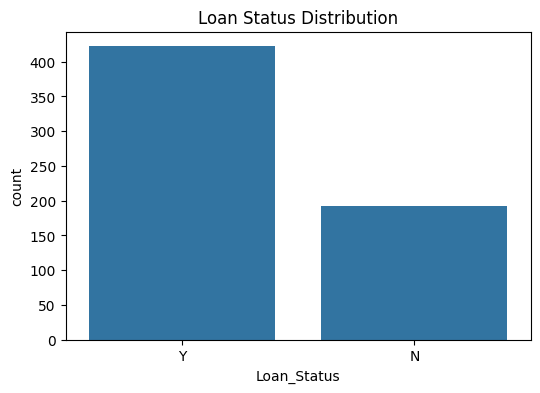

In [10]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Loan_Status')
plt.title('Loan Status Distribution')
plt.show()

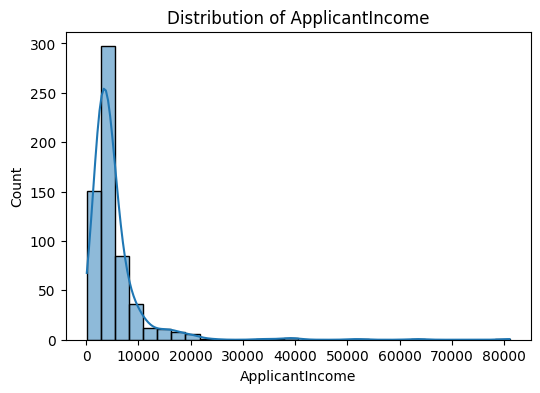

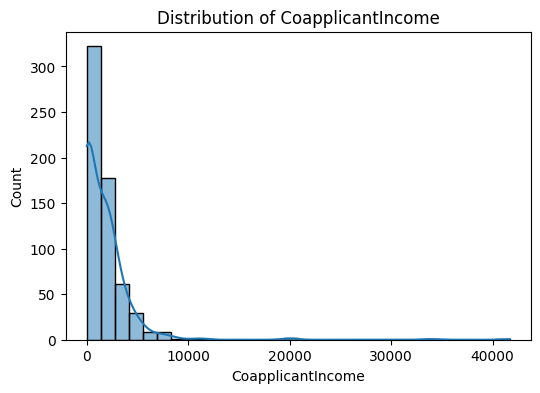

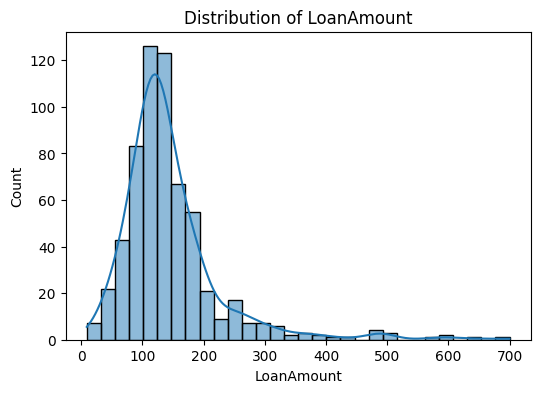

In [11]:
# Univariate Analysis for Numerical Variables
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

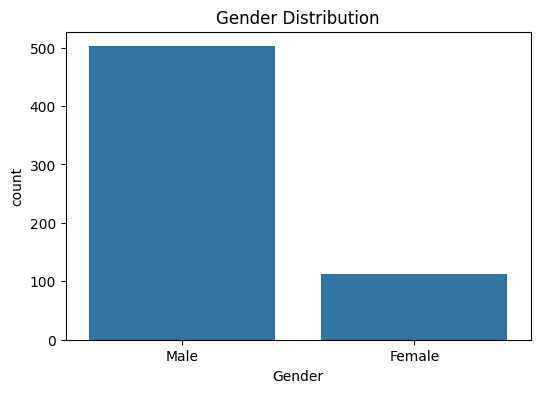

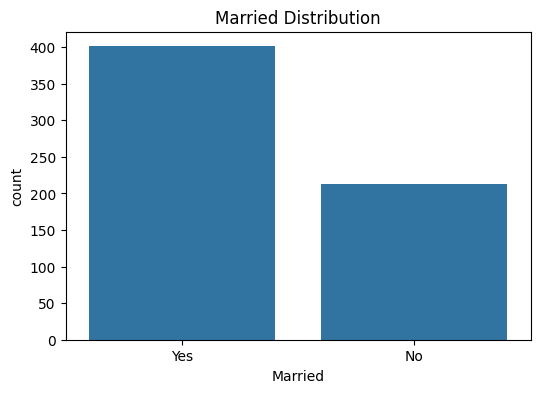

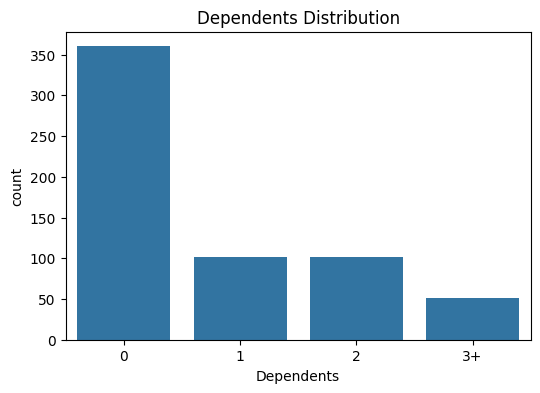

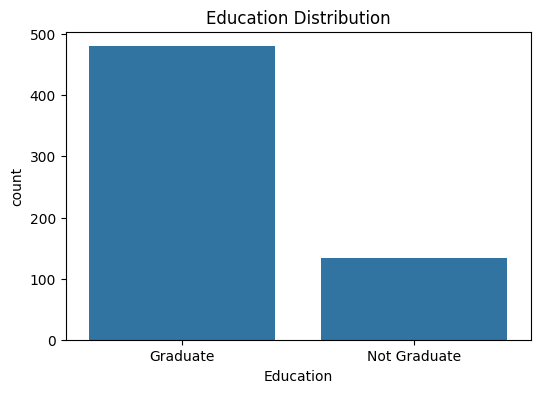

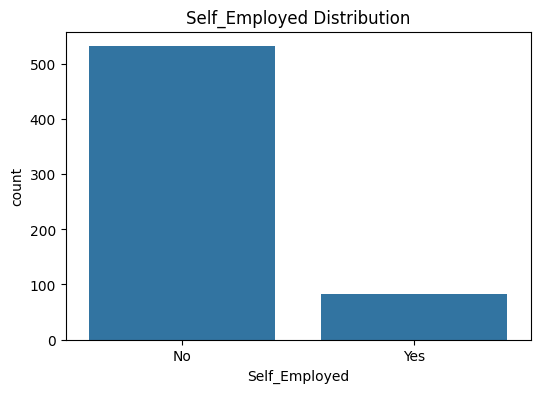

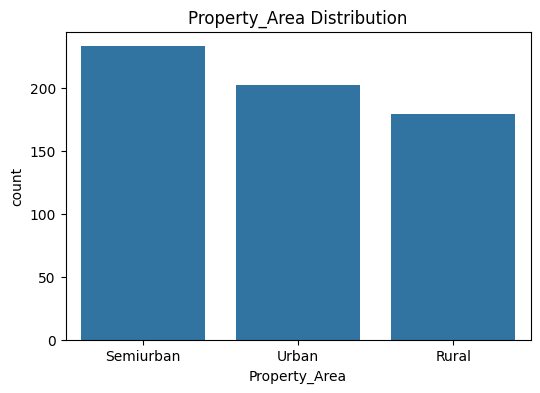

In [12]:
# Count plots for Categorical Features
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index)
    plt.title(f'{col} Distribution')
    plt.show()

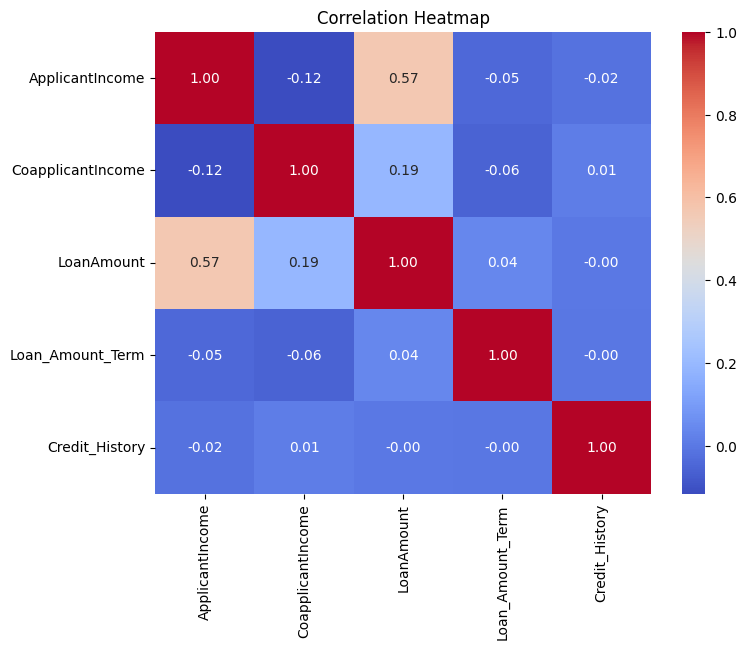

In [13]:
# Select only numerical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix for numerical columns
correlation_matrix = train_df[numerical_cols].corr()

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

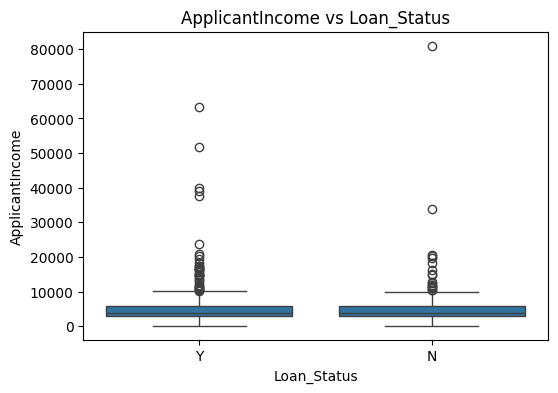

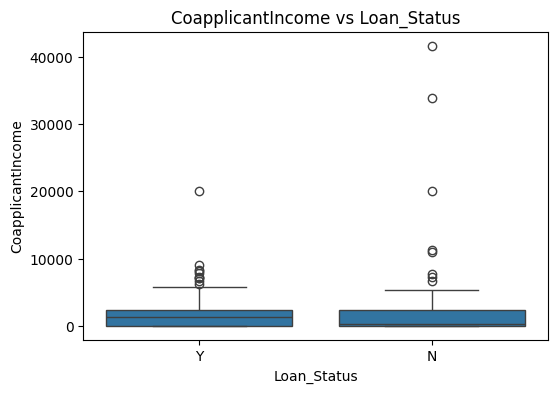

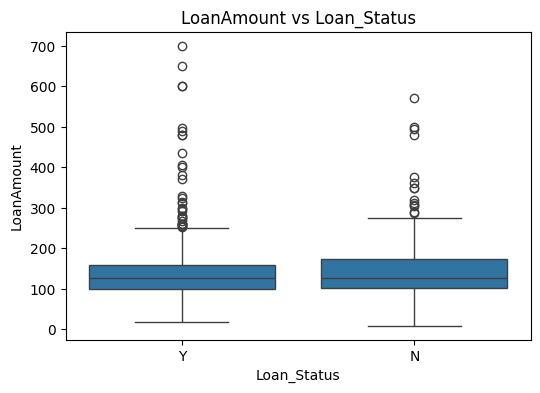

In [14]:
# Boxplots for Numerical Features vs Target
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_df, x='Loan_Status', y=col)
    plt.title(f'{col} vs Loan_Status')
    plt.show()

### Feature Engineering

In [15]:
# 1. Create TotalIncome
train_df['TotalIncome'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']

# 2. Create LoanToIncomeRatio
train_df['LoanToIncomeRatio'] = train_df['LoanAmount'] / train_df['TotalIncome']

In [16]:
# 3. Log Transform Skewed Features
skewed_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome']
for feature in skewed_features:
    train_df[feature] = np.log1p(train_df[feature])

In [18]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanToIncomeRatio
0,LP001002,Male,No,0,Graduate,No,8.674197,0.000000,4.859812,360.0,1.0,Urban,Y,8.674197,0.021884
1,LP001003,Male,Yes,1,Graduate,No,8.430327,7.319202,4.859812,360.0,1.0,Rural,N,8.714732,0.021015
2,LP001005,Male,Yes,0,Graduate,Yes,8.006701,0.000000,4.204693,360.0,1.0,Urban,Y,8.006701,0.022000
3,LP001006,Male,Yes,0,Not Graduate,No,7.857094,7.765993,4.795791,360.0,1.0,Urban,Y,8.505525,0.024287
4,LP001008,Male,No,0,Graduate,No,8.699681,0.000000,4.955827,360.0,1.0,Urban,Y,8.699681,0.023500


### Encoding of Categorical Variables

In [19]:
train1_df = train_df.copy()

In [20]:
train_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
TotalIncome          0
LoanToIncomeRatio    0
dtype: int64

Replace 3+ in Dependents

In [21]:
# Replace '3+' with 3 in the 'Dependents' column and convert to numeric
train_df['Dependents'] = train_df['Dependents'].replace('3+', 3).astype(int)

# Verify the transformation
print(train_df['Dependents'].value_counts())

Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: int64


In [22]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanToIncomeRatio
0,LP001002,Male,No,0,Graduate,No,8.674197,0.000000,4.859812,360.0,1.0,Urban,Y,8.674197,0.021884
1,LP001003,Male,Yes,1,Graduate,No,8.430327,7.319202,4.859812,360.0,1.0,Rural,N,8.714732,0.021015
2,LP001005,Male,Yes,0,Graduate,Yes,8.006701,0.000000,4.204693,360.0,1.0,Urban,Y,8.006701,0.022000
3,LP001006,Male,Yes,0,Not Graduate,No,7.857094,7.765993,4.795791,360.0,1.0,Urban,Y,8.505525,0.024287
4,LP001008,Male,No,0,Graduate,No,8.699681,0.000000,4.955827,360.0,1.0,Urban,Y,8.699681,0.023500


### Encoding of Categorical Variables

In [23]:
# Binary Encoding
train_df['Gender'] = train_df['Gender'].map({'Male': 1, 'Female': 0})
train_df['Married'] = train_df['Married'].map({'Yes': 1, 'No': 0})
train_df['Self_Employed'] = train_df['Self_Employed'].map({'Yes': 1, 'No': 0})
train_df['Loan_Status'] = train_df['Loan_Status'].map({'Y': 1, 'N': 0})

# One-Hot Encoding for Multi-Class Variables
train_df = pd.get_dummies(train_df, columns=['Property_Area', 'Education'], drop_first=True)

# Verify the dataset after encoding
print("Columns after encoding:", train_df.columns)


Columns after encoding: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'TotalIncome',
       'LoanToIncomeRatio', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Education_Not Graduate'],
      dtype='object')


In [24]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanToIncomeRatio,Property_Area_Semiurban,Property_Area_Urban,Education_Not Graduate
0,LP001002,1,0,0,0,8.674197,0.000000,4.859812,360.0,1.0,1,8.674197,0.021884,False,True,False
1,LP001003,1,1,1,0,8.430327,7.319202,4.859812,360.0,1.0,0,8.714732,0.021015,False,False,False
2,LP001005,1,1,0,1,8.006701,0.000000,4.204693,360.0,1.0,1,8.006701,0.022000,False,True,False
3,LP001006,1,1,0,0,7.857094,7.765993,4.795791,360.0,1.0,1,8.505525,0.024287,False,True,True
4,LP001008,1,0,0,0,8.699681,0.000000,4.955827,360.0,1.0,1,8.699681,0.023500,False,True,False


In [25]:
train2_df = train_df.copy()

In [26]:
train_df.isnull().sum()

Loan_ID                    0
Gender                     0
Married                    0
Dependents                 0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
TotalIncome                0
LoanToIncomeRatio          0
Property_Area_Semiurban    0
Property_Area_Urban        0
Education_Not Graduate     0
dtype: int64

In [27]:
# Convert boolean columns to integers
boolean_columns = ['Property_Area_Semiurban', 'Property_Area_Urban', 'Education_Not Graduate']
train_df[boolean_columns] = train_df[boolean_columns].astype(int)

# Verify the transformation
print(train_df[boolean_columns].head())


   Property_Area_Semiurban  Property_Area_Urban  Education_Not Graduate
0                        0                    1                       0
1                        0                    0                       0
2                        0                    1                       0
3                        0                    1                       1
4                        0                    1                       0


In [28]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanToIncomeRatio,Property_Area_Semiurban,Property_Area_Urban,Education_Not Graduate
0,LP001002,1,0,0,0,8.674197,0.000000,4.859812,360.0,1.0,1,8.674197,0.021884,0,1,0
1,LP001003,1,1,1,0,8.430327,7.319202,4.859812,360.0,1.0,0,8.714732,0.021015,0,0,0
2,LP001005,1,1,0,1,8.006701,0.000000,4.204693,360.0,1.0,1,8.006701,0.022000,0,1,0
3,LP001006,1,1,0,0,7.857094,7.765993,4.795791,360.0,1.0,1,8.505525,0.024287,0,1,1
4,LP001008,1,0,0,0,8.699681,0.000000,4.955827,360.0,1.0,1,8.699681,0.023500,0,1,0


### Scaling Numeric variables

In [29]:
train_df3 = train_df.copy()

In [30]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns to scale
numeric_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                   'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanToIncomeRatio']

# Initialize the scaler
scaler = StandardScaler()

# Scale numeric columns
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])

# Verify scaling
print("Scaled Numeric Variables (First 5 rows):")
print(train_df[numeric_columns].head())


Scaled Numeric Variables (First 5 rows):
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         0.516186          -1.107783   -0.012803          0.273231   
1         0.137806           0.782158   -0.012803          0.273231   
2        -0.519479          -1.107783   -1.348663          0.273231   
3        -0.751605           0.897526   -0.143351          0.273231   
4         0.555727          -1.107783    0.182981          0.273231   

   Credit_History  TotalIncome  LoanToIncomeRatio  
0        0.411733     0.008426          -0.229045  
1        0.411733     0.082860          -0.328983  
2        0.411733    -1.217299          -0.215721  
3        0.411733    -0.301306           0.047102  
4        0.411733     0.055223          -0.043308  


In [31]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanToIncomeRatio,Property_Area_Semiurban,Property_Area_Urban,Education_Not Graduate
0,LP001002,1,0,0,0,0.516186,-1.107783,-0.012803,0.273231,0.411733,1,0.008426,-0.229045,0,1,0
1,LP001003,1,1,1,0,0.137806,0.782158,-0.012803,0.273231,0.411733,0,0.082860,-0.328983,0,0,0
2,LP001005,1,1,0,1,-0.519479,-1.107783,-1.348663,0.273231,0.411733,1,-1.217299,-0.215721,0,1,0
3,LP001006,1,1,0,0,-0.751605,0.897526,-0.143351,0.273231,0.411733,1,-0.301306,0.047102,0,1,1
4,LP001008,1,0,0,0,0.555727,-1.107783,0.182981,0.273231,0.411733,1,0.055223,-0.043308,0,1,0


### Make a copy before Modelling

In [32]:
train_df_copy = train_df.copy()

In [33]:
train_df_copy.head()

,Loan_ID,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanToIncomeRatio,Property_Area_Semiurban,Property_Area_Urban,Education_Not Graduate
0,LP001002,1,0,0,0,0.516186,-1.107783,-0.012803,0.273231,0.411733,1,0.008426,-0.229045,0,1,0
1,LP001003,1,1,1,0,0.137806,0.782158,-0.012803,0.273231,0.411733,0,0.082860,-0.328983,0,0,0
2,LP001005,1,1,0,1,-0.519479,-1.107783,-1.348663,0.273231,0.411733,1,-1.217299,-0.215721,0,1,0
3,LP001006,1,1,0,0,-0.751605,0.897526,-0.143351,0.273231,0.411733,1,-0.301306,0.047102,0,1,1
4,LP001008,1,0,0,0,0.555727,-1.107783,0.182981,0.273231,0.411733,1,0.055223,-0.043308,0,1,0


### Train-Test Split

In [34]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train_df['Loan_Status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm the shapes of the splits
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (491, 14)
Testing Features Shape: (123, 14)
Training Target Shape: (491,)
Testing Target Shape: (123,)


### Model Training

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluation metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
        "Classification Report": classification_report(y_test, y_pred),
    }

# Display results
for model_name, metrics in results.items():
    print(f"--- {model_name} ---")
    for metric_name, value in metrics.items():
        if metric_name != "Classification Report":
            print(f"{metric_name}: {value:.4f}")
        else:
            print(value)
    print()

--- Logistic Regression ---
Accuracy: 0.8699
Precision: 0.8485
Recall: 0.9882
F1-Score: 0.9130
ROC-AUC: 0.8703
              precision    recall  f1-score   support

           0       0.96      0.61      0.74        38
           1       0.85      0.99      0.91        85

    accuracy                           0.87       123
   macro avg       0.90      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123


--- Random Forest ---
Accuracy: 0.8862
Precision: 0.8901
Recall: 0.9529
F1-Score: 0.9205
ROC-AUC: 0.8661
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        38
           1       0.89      0.95      0.92        85

    accuracy                           0.89       123
   macro avg       0.88      0.84      0.86       123
weighted avg       0.89      0.89      0.88       123


--- Gradient Boosting ---
Accuracy: 0.8293
Precision: 0.8478
Recall: 0.9176
F1-Score: 0.8814
ROC-AUC: 0.8412
              preci

c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Handling Class Imbalance

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Initialize models with class weights
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluation metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A",
        "Classification Report": classification_report(y_test, y_pred),
    }

# Display results
for model_name, metrics in results.items():
    print(f"--- {model_name} ---")
    for metric_name, value in metrics.items():
        if metric_name != "Classification Report":
            print(f"{metric_name}: {value:.4f}")
        else:
            print(value)
    print()

--- Logistic Regression ---
Accuracy: 0.8293
Precision: 0.8902
Recall: 0.8588
F1-Score: 0.8743
ROC-AUC: 0.8771
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        38
           1       0.89      0.86      0.87        85

    accuracy                           0.83       123
   macro avg       0.80      0.81      0.80       123
weighted avg       0.83      0.83      0.83       123


--- Random Forest ---
Accuracy: 0.8455
Precision: 0.8438
Recall: 0.9529
F1-Score: 0.8950
ROC-AUC: 0.8573
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        38
           1       0.84      0.95      0.90        85

    accuracy                           0.85       123
   macro avg       0.85      0.78      0.80       123
weighted avg       0.85      0.85      0.84       123


--- Gradient Boosting ---
Accuracy: 0.8293
Precision: 0.8478
Recall: 0.9176
F1-Score: 0.8814
ROC-AUC: 0.8412
              preci

c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Key Observations
1. Balanced Metrics:

Adding class weights has improved the balance between precision and recall for most models.

2. Best Overall Model:

Random Forest has the highest accuracy (84.55%) and F1-score (89.50%).
Recall (95.29%) is excellent for predicting approved loans (Loan_Status = 1).

3. Best for High Recall:

Naive Bayes has the highest recall (97.65%), ensuring very few false negatives (missed loan approvals).

4. Logistic Regression:

Shows strong precision (89.02%) and balanced performance with high ROC-AUC (87.71%).

5. Support Vector Machine:

Competitive with accuracy (85.37%) and F1-score (89.66%), with a good trade-off between precision and recall.

6. XGBoost:

Performs well but slightly lags behind other models like Random Forest and Logistic Regression.


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples to split
    'min_samples_leaf': [1, 2, 4],  # Min samples at leaf nodes
    'max_features': ['auto', 'sqrt', 'log2'],  # Features to consider at each split
    'class_weight': ['balanced']  # Handle class imbalance
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    scoring='f1',  # Optimize based on F1-Score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all processors
)

# Perform the search
random_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best Parameters:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)

# Use the best model to make predictions on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the best model
from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
if hasattr(best_rf, 'predict_proba'):
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
    print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
65 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\REGIA CRABBE\AppData\Local\Programs\Python\Python312\Lib\

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced'}
Best F1-Score: 0.8560186953131401
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123

Test ROC-AUC: 0.8780185758513932
